In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
from scipy.stats import linregress

In [2]:
import sys
sys.path.append('..')
from ridesharing_simulation import *

### re-run 100 weeks after set up with the short-term rider and driver's elasticity

In [3]:
start_week = 0
T0_pricing_params = (5, 0.78, 1.82)
lr = 0.01

In [4]:
demand_columns = ["request_timestamp", "x_start", "y_start", "x_end", "y_end"
                    , "rider_idx", "trip_start_subblock_id", "trip_end_subblock_id"]
supply_columns = ["idle_start_timestamp", "idle_duration", "idle_x_start", "idle_y_start"
                   , "driver_idx", "idle_start_subblock_id"]

In [5]:
total_weeks = 100

stdout_logger = utils.create_logger_custom("weekly_daily_main_function")

for w in tqdm(range(total_weeks)):
    simulation_this_week = WeeklySimulation(w, lr, T0_pricing_params)
    for d in range(7):
        drivers_this_week_today = simulation_this_week.simulate_supply()
        requests_this_week_today = simulation_this_week.simulate_demand()

        lst1 = []
        for row in simulation_this_week.D_Requests:
            row_dict = {demand_columns[i]: row[i].item() for i in range(row.size(0))}
            lst1.append(row_dict)

        # Save each dictionary as a JSON object in a JSON file
        with open('../data/100_weeks_a_r1.5_b_r-0.2_b_d_-0.3_a_l-0.0001_b_l_22.5672/demand_week_'+str(w)+'.json', 'w') as json_file:
            json.dump(lst1, json_file, indent=4)

        lst2 = []
        for row in simulation_this_week.S_Drivers:
            row_dict = {supply_columns[i]: row[i].item() for i in range(row.size(0))}
            lst2.append(row_dict)

        # Save each dictionary as a JSON object in a JSON file
        with open('../data/100_weeks_a_r1.5_b_r-0.2_b_d_-0.3_a_l-0.0001_b_l_22.5672/supply_week_'+str(w)+'.json', 'w') as json_file:
            json.dump(lst2, json_file, indent=4)

        # Save each dictionary as a JSON object in a JSON file
        with open('../data/100_weeks_a_r1.5_b_r-0.2_b_d_-0.3_a_l-0.0001_b_l_22.5672/exposed_prices_week_'+str(w)+'.json', 'w') as json_file:
            json.dump(simulation_this_week.exposed_prices, json_file, indent=4)

        simulation_this_week.request_driver_matching(verbose=1)
        #simulation_this_week.update_gamma_distns()
        std_out_entry = {
            "week": w,
            "day": d,
            "drivers_size": list(drivers_this_week_today.size()),
            "requests_size": list(requests_this_week_today.size())
        }
        stdout_logger.debug(json.dumps(std_out_entry))

        simulation_this_week.update_lambda_longterm_elasticity()

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:47<00:00,  2.11it/s]


In [6]:
#lambda will be fix if we don't sample from gamma distributions
lambda_riders_df = pd.DataFrame({'lambda_riders': simulation_this_week.lambda_riders.tolist()})

In [7]:
lambda_riders_df.describe()

,lambda_riders
count,1000.000000
mean,0.897107
std,0.125063
min,0.772107
25%,0.772107
50%,0.897107
75%,1.022107
max,1.022107


In [8]:
weekly_sim_log_df = pd.read_json("../data/100_weeks_a_r1.5_b_r-0.2_b_d_-0.3_a_l-0.0001_b_l_22.5672/logfile_matched_trips_week_0_.log", lines=True)

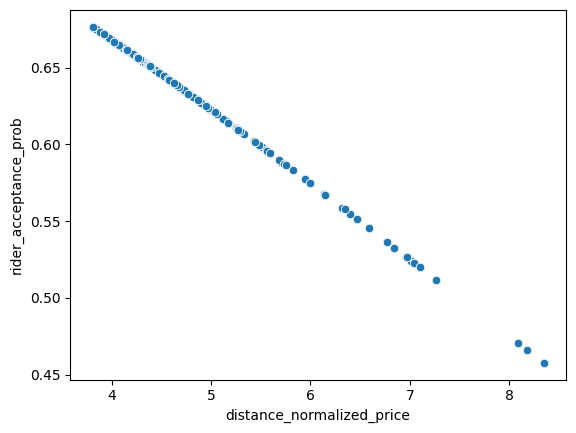

In [9]:
sns.scatterplot(data=weekly_sim_log_df, x='distance_normalized_price', y='rider_acceptance_prob')
plt.show()

In [10]:
slope, intercept, r_value, p_value, std_err = linregress(weekly_sim_log_df['distance_normalized_price']
                                                         , weekly_sim_log_df['rider_acceptance_prob'])
slope, intercept, r_value, p_value, std_err

(-0.047390883878067516,
 0.8583537249822616,
 -0.9997546311418469,
 0.0,
 2.9878994744524034e-05)

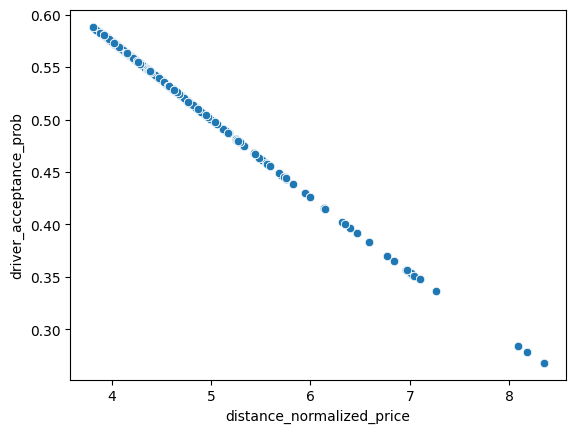

In [11]:
sns.scatterplot(data=weekly_sim_log_df, x='distance_normalized_price', y='driver_acceptance_prob')
plt.show()

In [12]:
slope, intercept, r_value, p_value, std_err = linregress(weekly_sim_log_df['distance_normalized_price']
                                                         , weekly_sim_log_df['driver_acceptance_prob'])
slope, intercept, r_value, p_value, std_err

(-0.07338840310239729,
 0.8676757070054967,
 -0.9998082742431842,
 0.0,
 4.0898901476851826e-05)

In [13]:
weekly_sim_log_df.shape

(1237, 12)

In [14]:
weekly_sim_log_df.columns

Index(['current_day', 'square_index', 'rider_id', 'driver_idx',
       'trip_start_timestamp', 'trip_duration', 'ride_miles',
       'trip_end_timestamp', 'price_of_ride', 'distance_normalized_price',
       'rider_acceptance_prob', 'driver_acceptance_prob'],
      dtype='object')

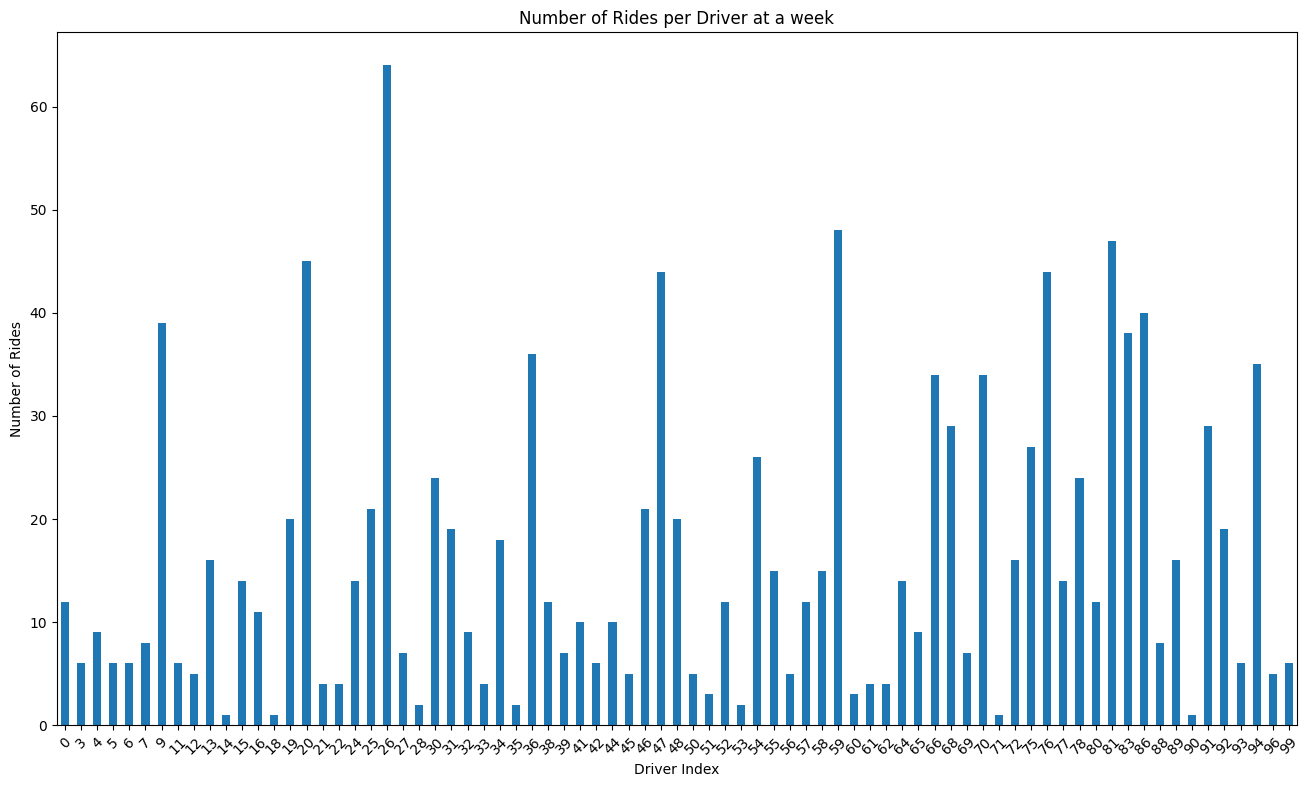

In [15]:
weekly_riders_per_driver = weekly_sim_log_df.groupby('driver_idx')['rider_id'].count()
weekly_riders_per_driver.plot(kind='bar', figsize=(16, 9))
plt.xlabel('Driver Index')
plt.ylabel('Number of Rides')
plt.title('Number of Rides per Driver at a week')
plt.xticks(rotation=45)
plt.show()

### as shown below, on avg. a driver did 25.89 riders per week

In [16]:
weekly_sim_log_df.groupby('driver_idx')['rider_id'].count().mean()

16.064935064935064

In [17]:
weekly_sim_log_df['distance_normalized_price'].mean(), weekly_sim_log_df['rider_acceptance_prob'].mean()

(4.565369118835894, 0.6419968472109944)

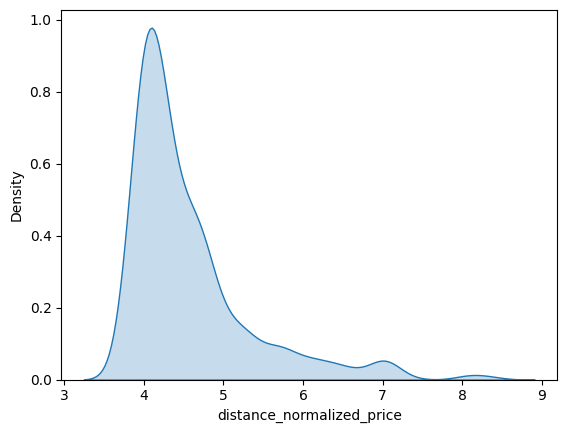

In [18]:
sns.kdeplot(data=weekly_sim_log_df['distance_normalized_price'], fill=True)
plt.show()

### multi-normal distribution on 8am(480) and 6pm(1080)

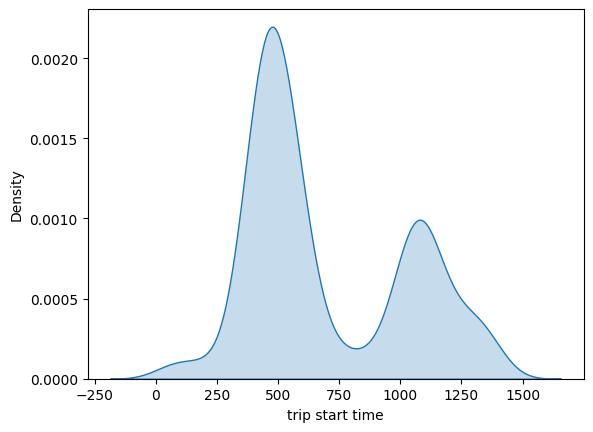

In [19]:
sns.kdeplot(data=weekly_sim_log_df['trip_start_timestamp'], fill=True)
plt.xlabel('trip start time')
plt.show()

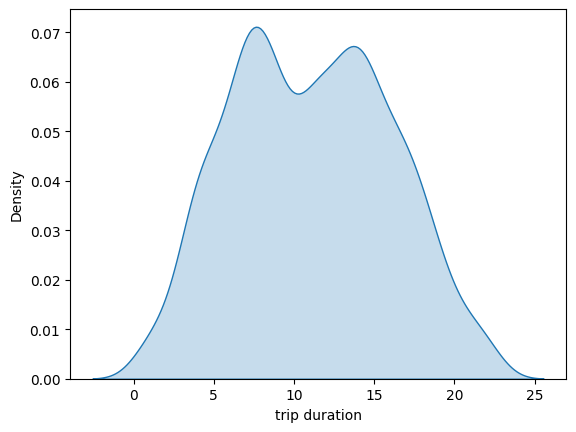

In [20]:
sns.kdeplot(data=weekly_sim_log_df['trip_duration'], fill=True)
plt.xlabel('trip duration')
plt.show()

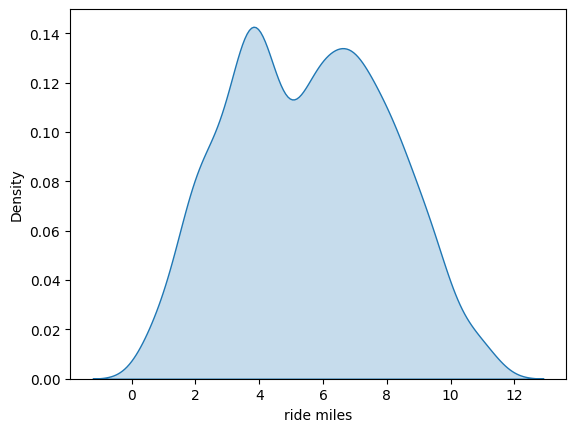

In [21]:
sns.kdeplot(data=weekly_sim_log_df['ride_miles'], fill=True)
plt.xlabel('ride miles')
plt.show()

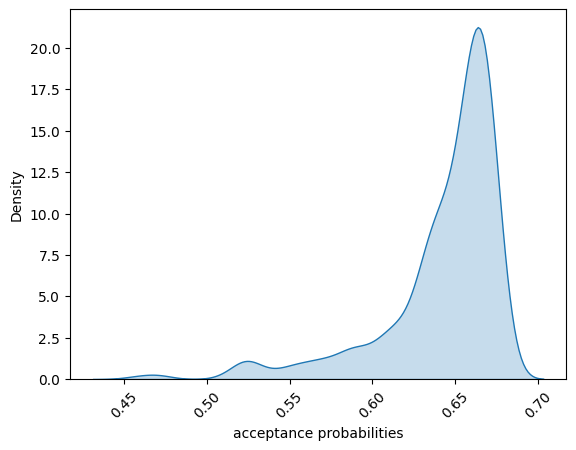

In [22]:
sns.kdeplot(data=weekly_sim_log_df['rider_acceptance_prob'], fill=True)
plt.xlabel('acceptance probabilities')
plt.xticks(rotation=45) 
plt.show()

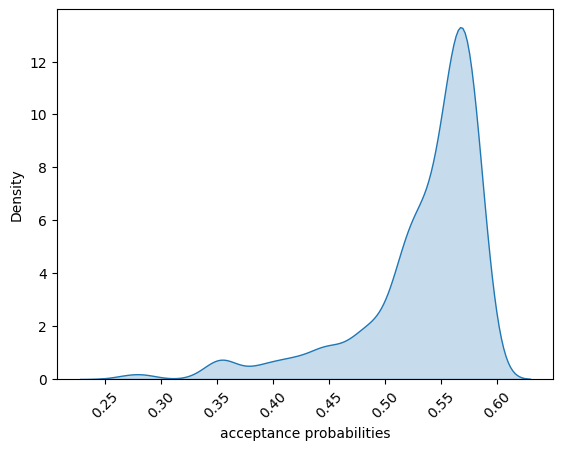

In [23]:
sns.kdeplot(data=weekly_sim_log_df['driver_acceptance_prob'], fill=True)
plt.xlabel('acceptance probabilities')
plt.xticks(rotation=45) 
plt.show()

In [24]:
daily_avg_price_lst, daily_total_requests = [], []
for i in range(100):
    prices_df = pd.read_json('../data/100_weeks_a_r1.5_b_r-0.2_b_d_-0.3_a_l-0.0001_b_l_22.5672/exposed_prices_week_'+str(i)+'.json')
    requests_df = pd.read_json('../data/100_weeks_a_r1.5_b_r-0.2_b_d_-0.3_a_l-0.0001_b_l_22.5672/demand_week_'+str(i)+'.json')
    daily_avg_price_lst.append(prices_df.price_of_ride.mean()) 
    daily_total_requests.append(len(requests_df))

In [25]:
sum(daily_avg_price_lst[:25])/len(daily_avg_price_lst[:25])

22.571055905698824

In [26]:
sum(daily_avg_price_lst[:50])/len(daily_avg_price_lst[:50]), sum(daily_avg_price_lst[:75])/len(daily_avg_price_lst[:75])

(22.56465532963062, 22.565338625798724)

In [27]:
sum(daily_avg_price_lst)/len(daily_avg_price_lst)

22.561041234356257

In [28]:
prices_df.head(2)

,price_of_ride,distance_normalized_price,trip_duration,rider_acceptance_prob,driver_acceptance_prob
0,18.1918,4.7627,8,0.6335,0.5178
1,16.8365,4.8055,7,0.6316,0.5146


In [29]:
long_term_rider_elasticity_df = pd.DataFrame({'daily_avg_price': daily_avg_price_lst, 'daily_total_requests': daily_total_requests})

In [30]:
long_term_rider_elasticity_df.daily_avg_price.describe()

count    100.000000
mean      22.561041
std        0.358713
min       21.868161
25%       22.274005
50%       22.595340
75%       22.759691
max       23.423612
Name: daily_avg_price, dtype: float64

In [31]:
long_term_rider_elasticity_df.daily_total_requests.describe()

count    100.000000
mean     867.990000
std       40.223239
min      765.000000
25%      841.000000
50%      865.500000
75%      899.250000
max      977.000000
Name: daily_total_requests, dtype: float64

In [32]:
#long_term_rider_elasticity_df['daily_avg_price_change'] = long_term_rider_elasticity_df['daily_avg_price'].pct_change()

In [33]:
#long_term_rider_elasticity_df['daily_total_requests_change'] = long_term_rider_elasticity_df['daily_total_requests'].pct_change()

In [34]:
long_term_rider_elasticity_df.daily_avg_price.mean(), long_term_rider_elasticity_df.daily_total_requests.mean()

(22.561041234356253, 867.99)

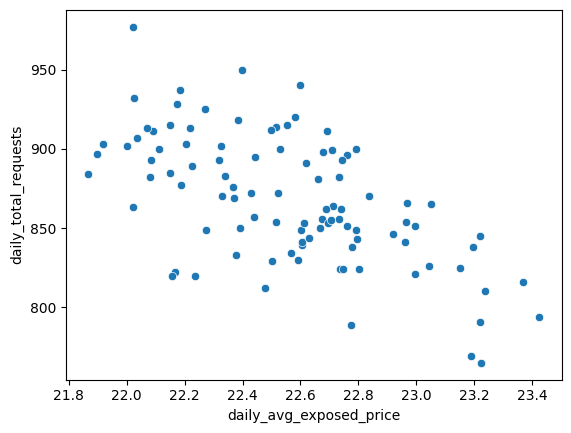

In [35]:
sns.scatterplot(data=long_term_rider_elasticity_df, x='daily_avg_price', y='daily_total_requests')
plt.xlabel('daily_avg_exposed_price')
plt.show()

In [39]:
long_term_rider_elasticity_df['daily_avg_price'].mean(), long_term_rider_elasticity_df['daily_total_requests'].mean()

(22.561041234356253, 867.99)

In [40]:
1/long_term_rider_elasticity_df['daily_avg_price'].mean(), -67.67409299173185/long_term_rider_elasticity_df['daily_total_requests'].mean()

(0.04432419539560908, -0.07796644315226195)

In [36]:
slope, intercept, r_value, p_value, std_err = linregress(long_term_rider_elasticity_df['daily_avg_price']
                                                         , long_term_rider_elasticity_df['daily_total_requests'])
slope, intercept, r_value, p_value, std_err

(-67.67409299173185,
 2394.788002484122,
 -0.6035204679793352,
 3.0110259546204737e-11,
 9.031607227225397)

### as below, the ride share company makes $7.12 per ride

In [37]:
round(weekly_sim_log_df['price_of_ride'].mean(), 2), weekly_sim_log_df['price_of_ride'].sum()

(23.73, 29357.6581)

In [38]:
round(weekly_sim_log_df['price_of_ride'].mean()*0.3, 2)

7.12